# Oil, Gold, NASDAQ, and USD-index dataset

- Oil: Brent daily in USD from https://www.eia.gov/dnav/pet/hist/RBRTEd.htm
- Gold: LMBA gold daily at 10:30AM in USD from https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM
- NASDAQ: adjusted closing price (daily) from https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC
- USD index: traded weighted on broad currency index from https://fred.stlouisfed.org/series/TWEXB

In [1]:
import mogptk
import numpy as np

%reload_ext autoreload
%autoreload 2

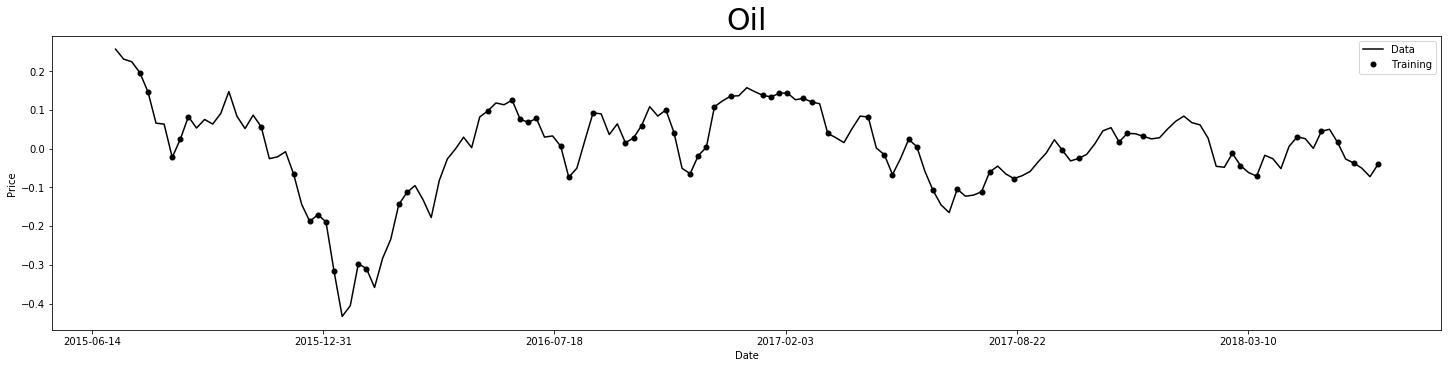

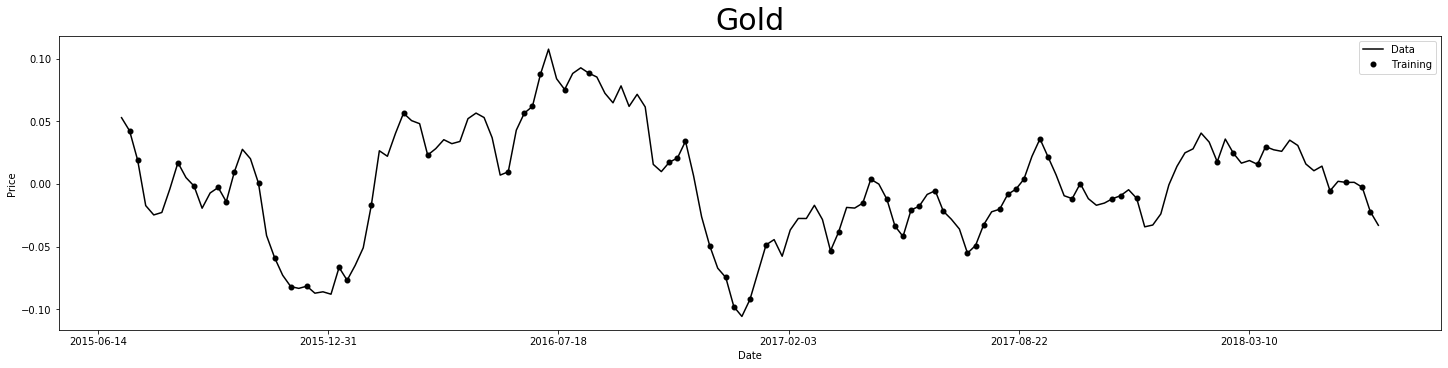

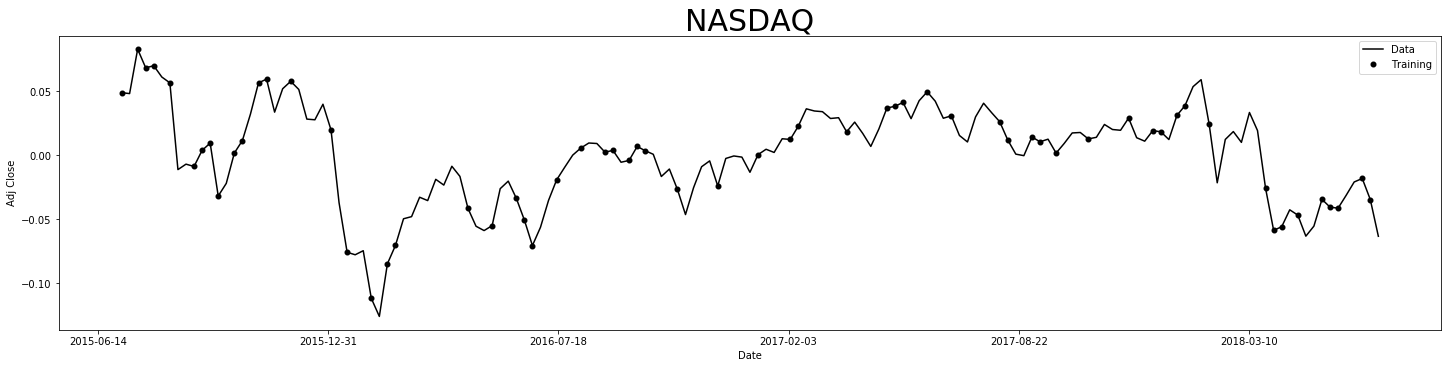

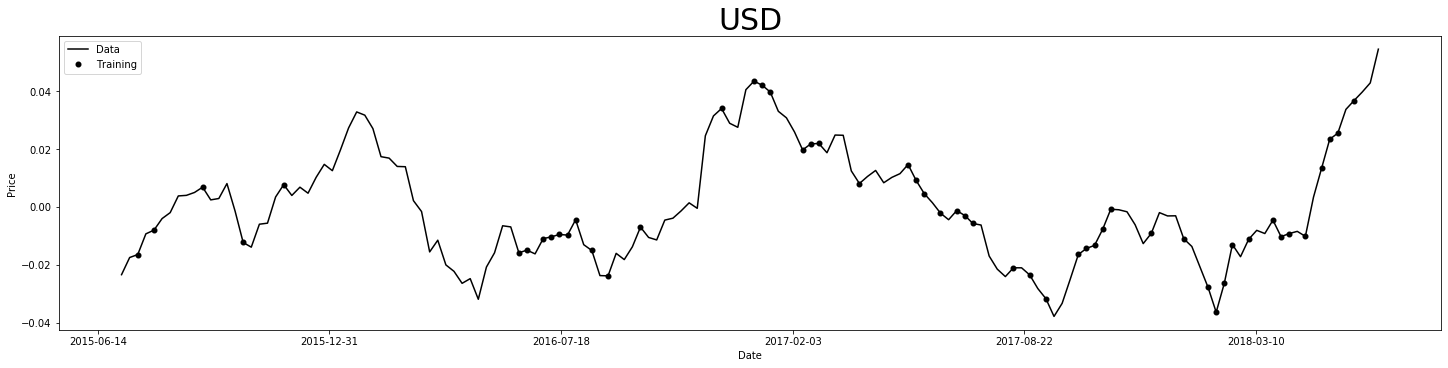

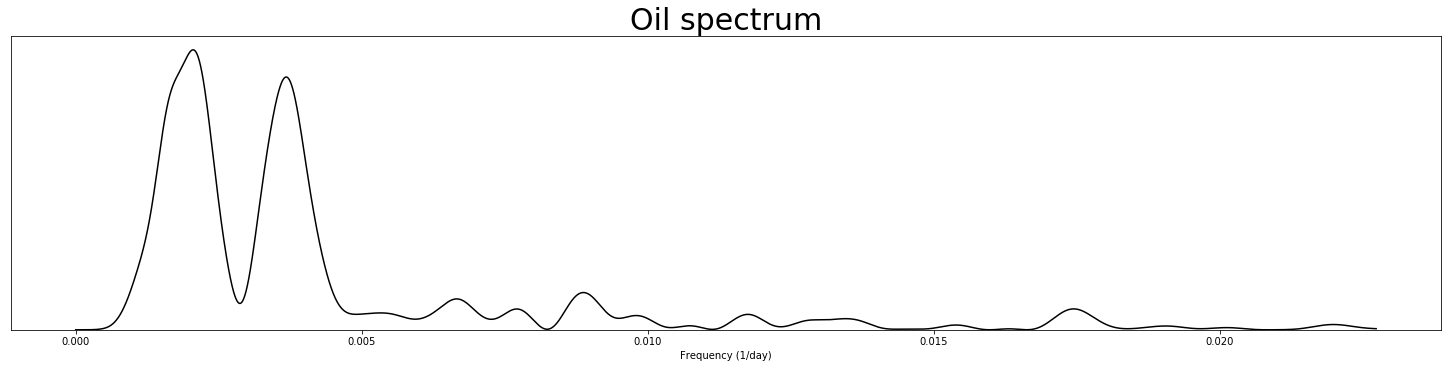

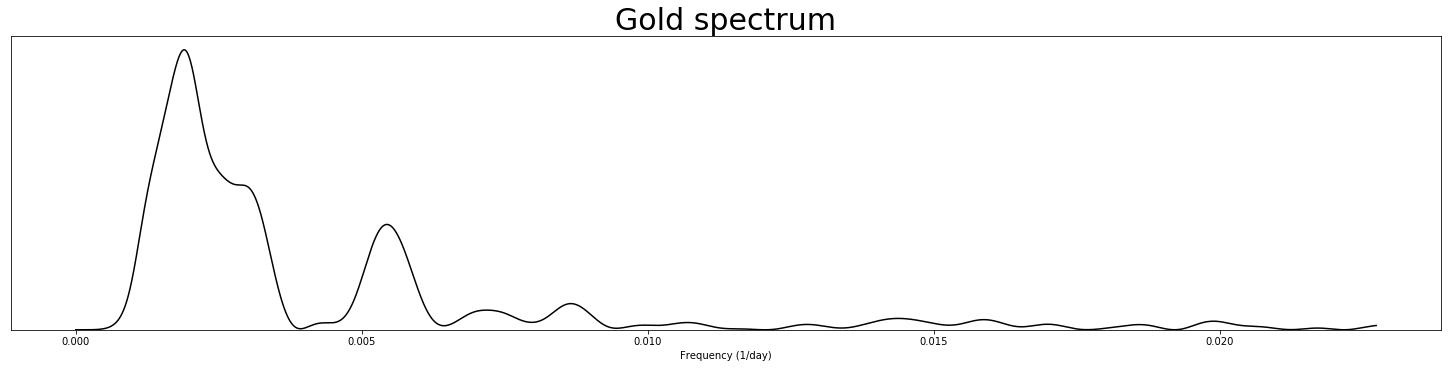

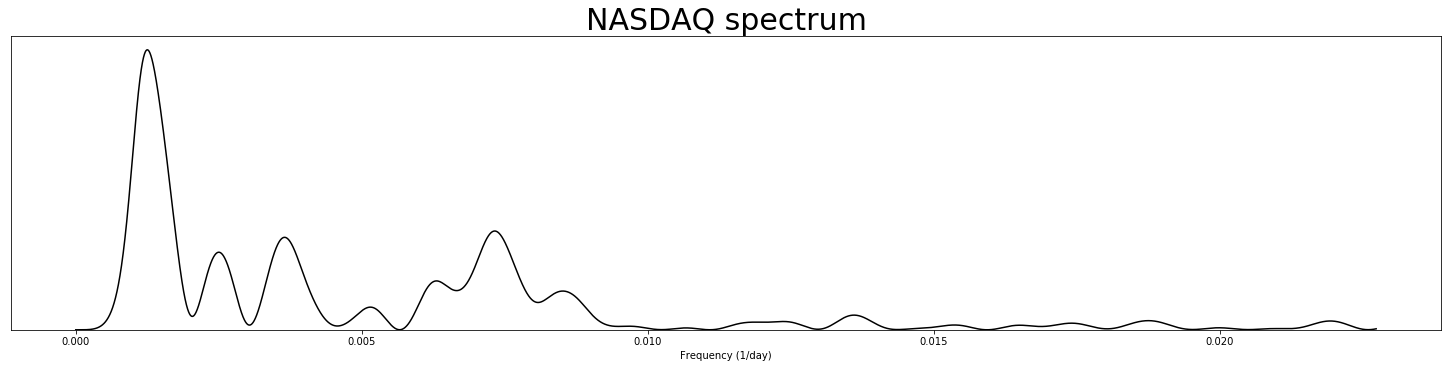

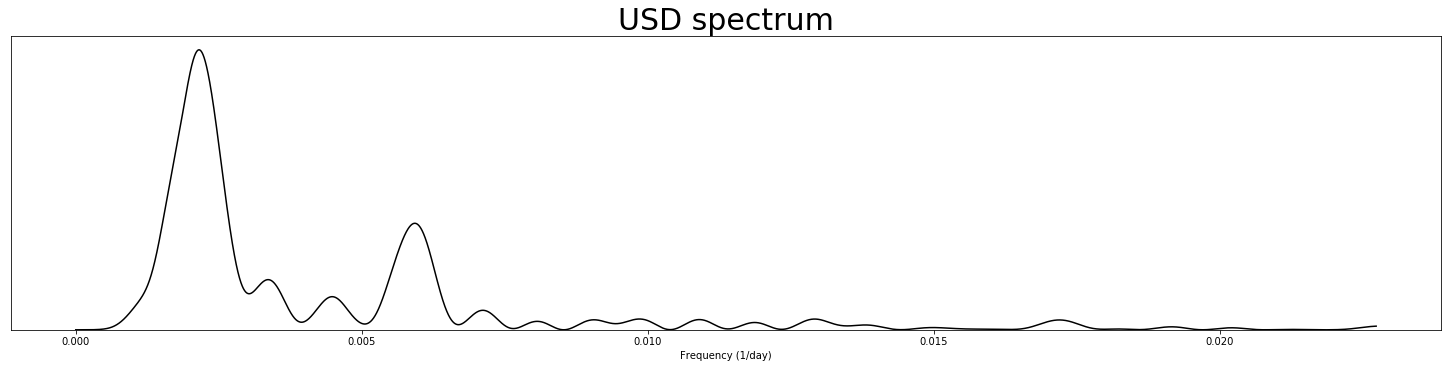

In [2]:
oil = mogptk.LoadCSV('datahub/brent-daily.csv', 'Date', 'Price', name='Oil', format={'Date': mogptk.FormatDate})
gold = mogptk.LoadCSV('lmba-gold-usd-am-daily.csv', 'Date', 'Price', name='Gold', format={'Date': mogptk.FormatDate})
nasdaq = mogptk.LoadCSV('yahoo/nasdaq.csv', 'Date', 'Adj Close', name='NASDAQ', format={'Date': mogptk.FormatDate})
usd = mogptk.LoadCSV('TWEXB.csv', 'Date', 'Price', name='USD', format={'Date': mogptk.FormatDate})

data = [oil, gold, nasdaq, usd]

for i, channel in enumerate(data):
    channel.filter('2015-07-01', '2018-07-01')
    channel.aggregate('7d')
    
    channel.transform(mogptk.TransformLog)
    channel.transform(mogptk.TransformDetrend)
    
    channel.remove_randomly(pct=0.6)
    if i == 3:
        channel.remove_range('2016-01-01', '2016-06-01')
    
    channel.plot()
    
for i, channel in enumerate(data):
    channel.plot_spectrum(per='day')    
    #print('BNSE:', channel.get_bnse_estimation())
    #print('LombScargle:', channel.get_ls_estimation())
    
oil.set_pred_range('2015-07-01', '2018-07-01', n=1000)
gold.set_pred_range('2015-07-01', '2018-07-01', n=1000)
nasdaq.set_pred_range('2015-07-01', '2018-07-01', n=1000)
usd.set_pred_range('2015-07-01', '2018-07-01', n=1000)

## MOSM

In [5]:
mosm = mogptk.MOSM(data, Q=3)
mosm.init_params()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -587.345722
  Number of iterations: 738
  Number of functions evaluations: 810
Done in  1.2148292342821756  minutes


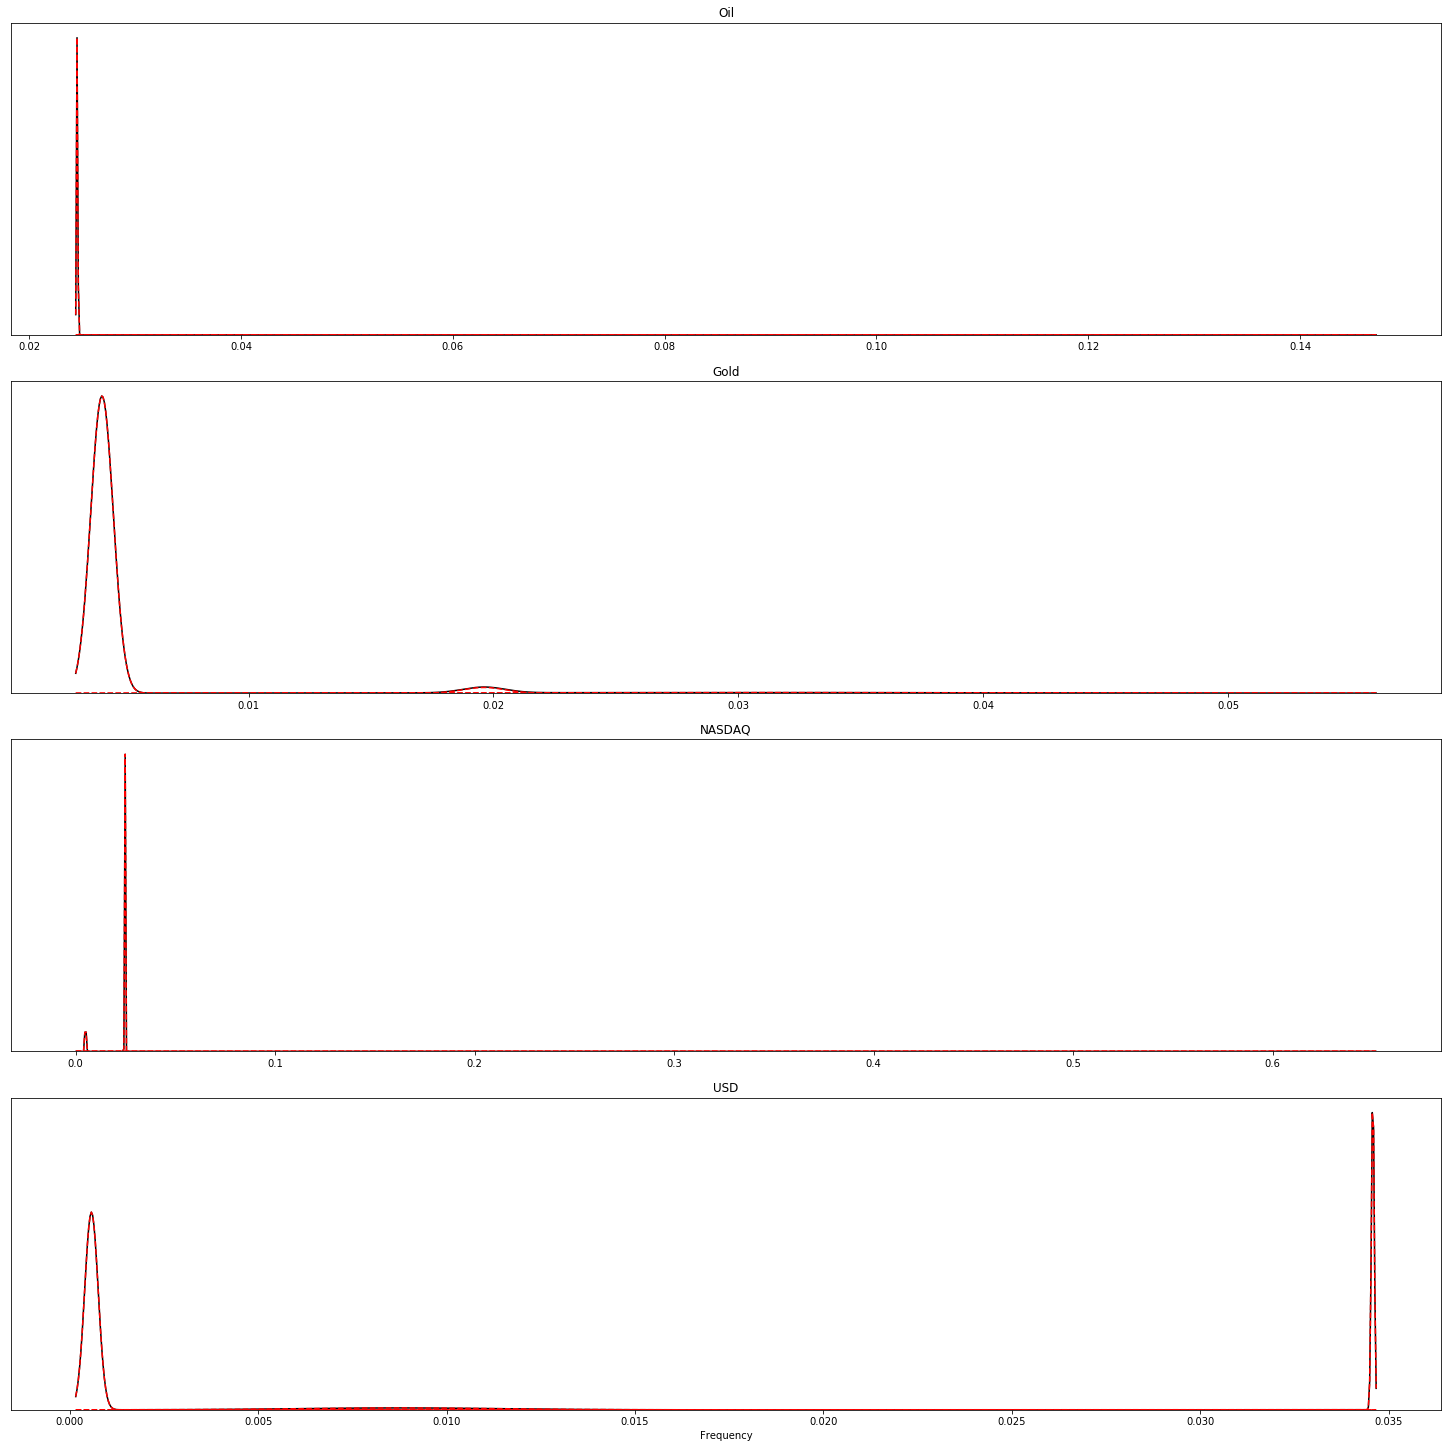

,magnitude,mean,variance,delay,phase,noise
Q,,,,,,
0,"[0.9686818656916465, 0.16508435653955567, 0.2195604670289425, -0.02807281387088217]","[[0.02453116102818342, 0.004019686195722994, 0.024688175519574754, 0.008726855745748406]]","[[5.802630340063749e-05, 0.00046102470115040725, 0.00017313619311509502, 0.002594745576803681]]","[[0.0, -0.6994762805774775, 0.5072709753088929, 0.5339370102136213]]","[0.0, 1.045676007054796, -1.0905279430278092, 0.9197182642421772]","[0.02425588026217586, 0.14760607467642306, 0.09844063655862885, 0.05999953388541082]"
1,"[0.07500396589235765, -0.0379570531854472, -0.0977755585554209, 0.07576795646527584]","[[0.038780110235366, 0.02978994441588682, 0.0048950939122359245, 0.0005757826013609782]]","[[0.0006833998802721107, 0.011279786609771759, 0.00022389332988826822, 0.00017921437207502145]]","[[0.0, 0.7419584034463319, 0.2595898461162987, -0.6193834491476459]]","[0.0, 0.7583160764259295, 1.1087131586393608, 0.8850462176128]","[0.024433366742833102, 0.13941577190272572, 0.09630306427392717, 0.0779648132592401]"
2,"[-0.09094828415301583, -0.031387706576499995, -0.010629806460126309, 0.04453324042010951]","[[0.12915509244540116, 0.01961776353552372, 0.04289254759344892, 0.03457844603902655]]","[[0.007755284485173267, 0.0008628842183783269, 0.2618047355824524, 3.8082200843125265e-05]]","[[0.0, -0.15483573323545977, -0.5741652768666304, -0.09705124504062901]]","[0.0, -1.5982042996083625, -0.02869814785955549, -0.39818767537973887]","[0.02386128077988285, 0.08786157722575182, 0.0634627757187169, 0.09197879539100157]"


‣ MOSM approaches RBF kernel for Q=2 in channel='NASDAQ'


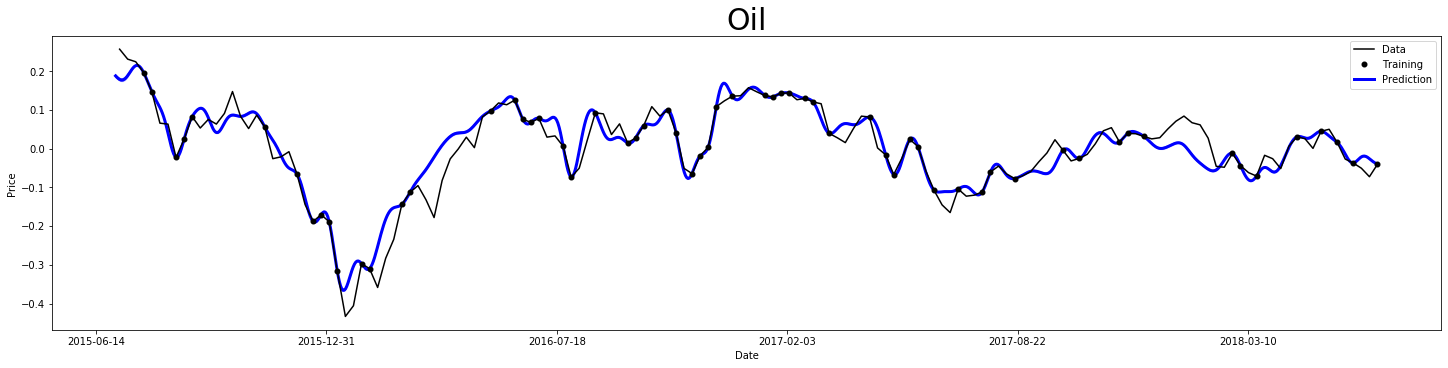

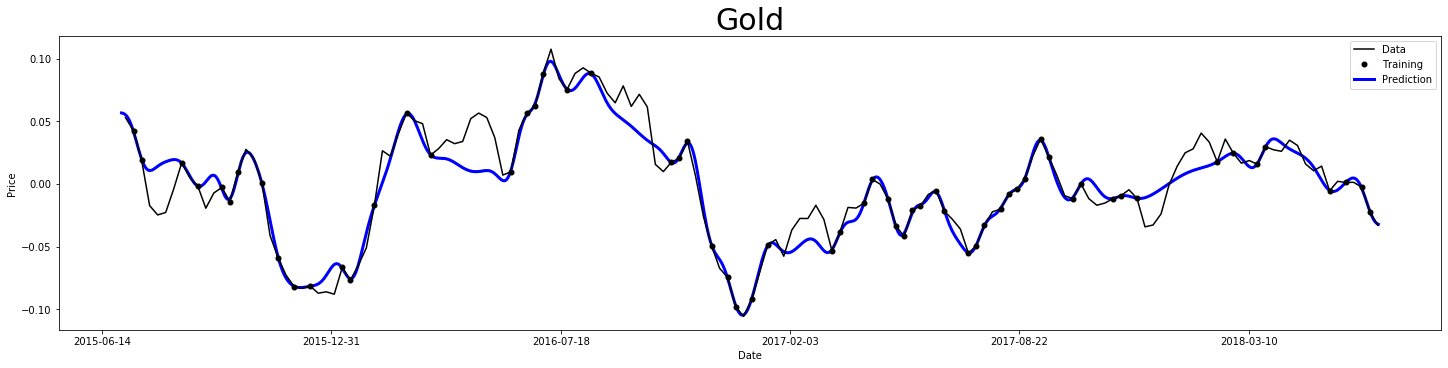

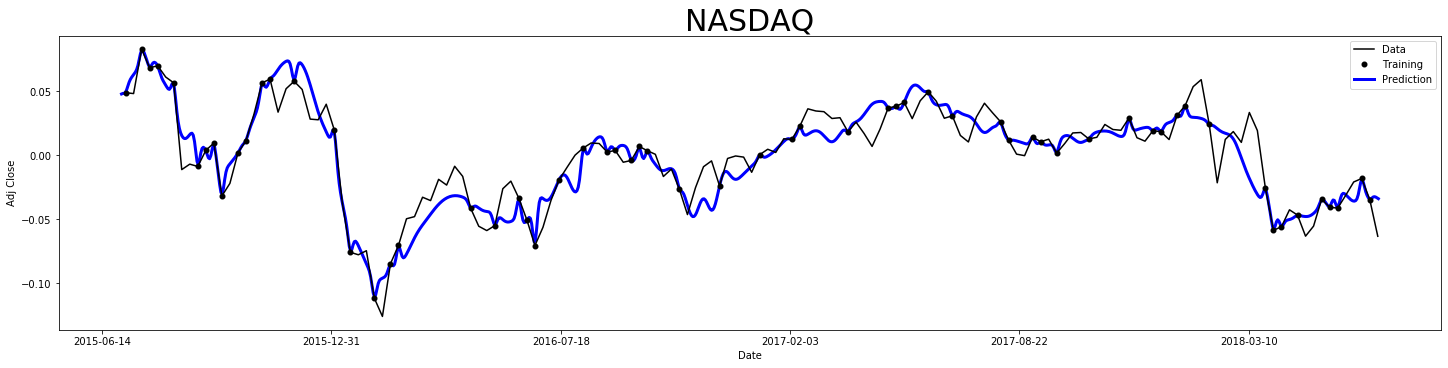

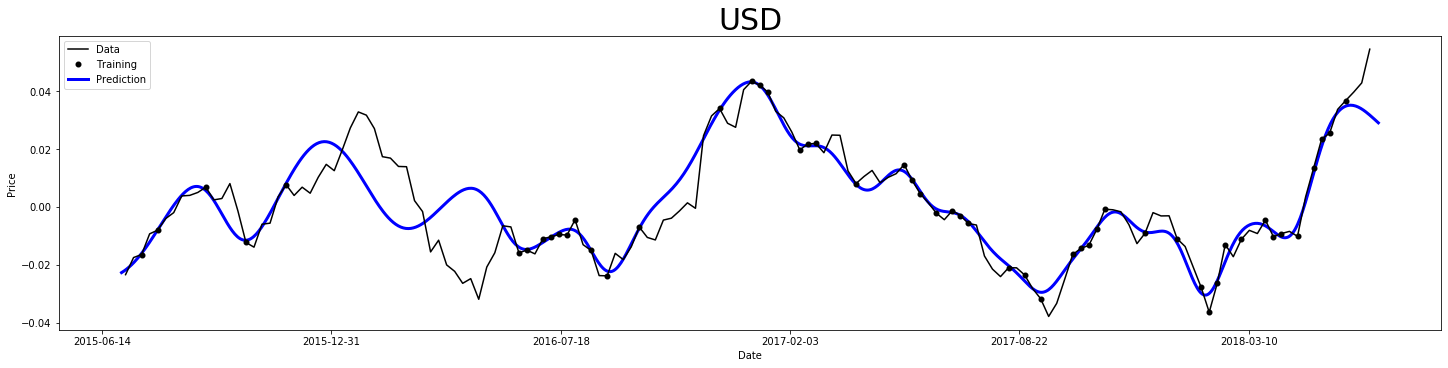

In [9]:
mosm.train(tol=1e-6, maxiter=2000)
mosm.plot()
mosm.print()
mosm.info()

mosm.predict()
mosm.plot_data()

## CSM

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -529.791178
  Number of iterations: 110
  Number of functions evaluations: 151
Done in  0.3780933419863383  minutes


,constant,mean,variance,phase
Q,,,,
0,"[[0.002942290817577644, 1.0578683222361546e-06, 0.0014982879643217698, 1.001038650942491e-06]]",[0.021348049680151707],[0.00028748309543035166],"[[1.0000000002220446e-06, 1.0000000002220446e-06, 1.0000000002220446e-06, 1.0000000002220446e-06]]"
1,"[[0.0068388961289325145, 0.0016137067011969912, 1.0014123797676975e-06, 1.0000562352386864e-06]]",[2.6009284441567445e-05],[0.0015269573643749308],"[[1.0000000002220446e-06, 1.0000000002220446e-06, 1.0000000002220446e-06, 1.0000000002220446e-06]]"
2,"[[0.011760911524219536, 1.0009692660003246e-06, 1.0084280386758563e-06, 0.00020496633619812037]]",[0.0027345376837363215],[0.005028103336254865],"[[1.0000000002220446e-06, 1.0000000002220446e-06, 1.0000000002220446e-06, 1.0000000002220446e-06]]"


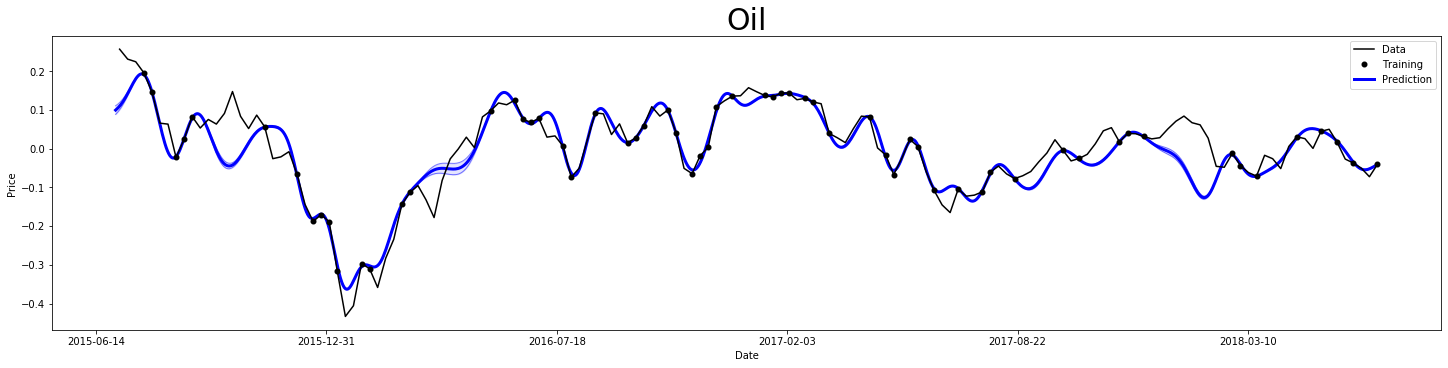

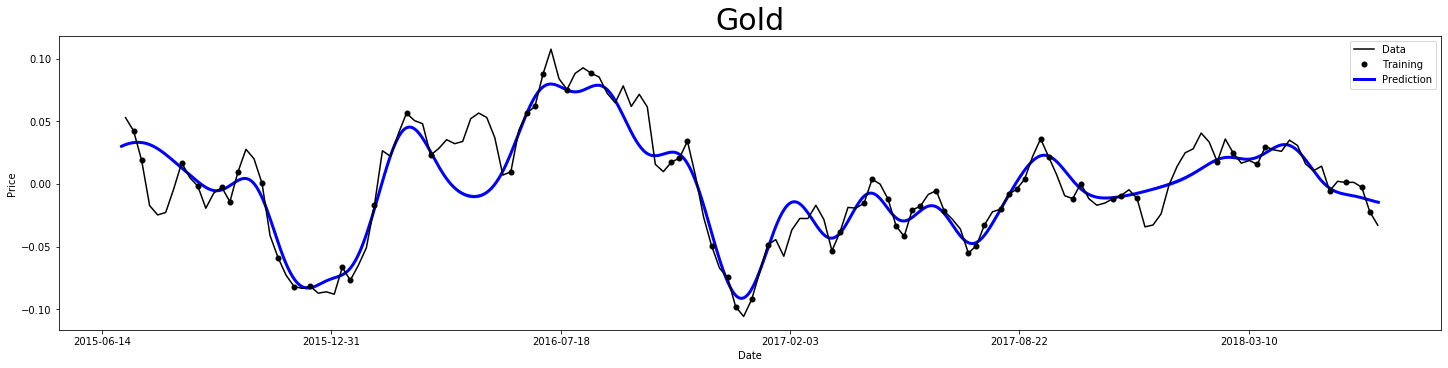

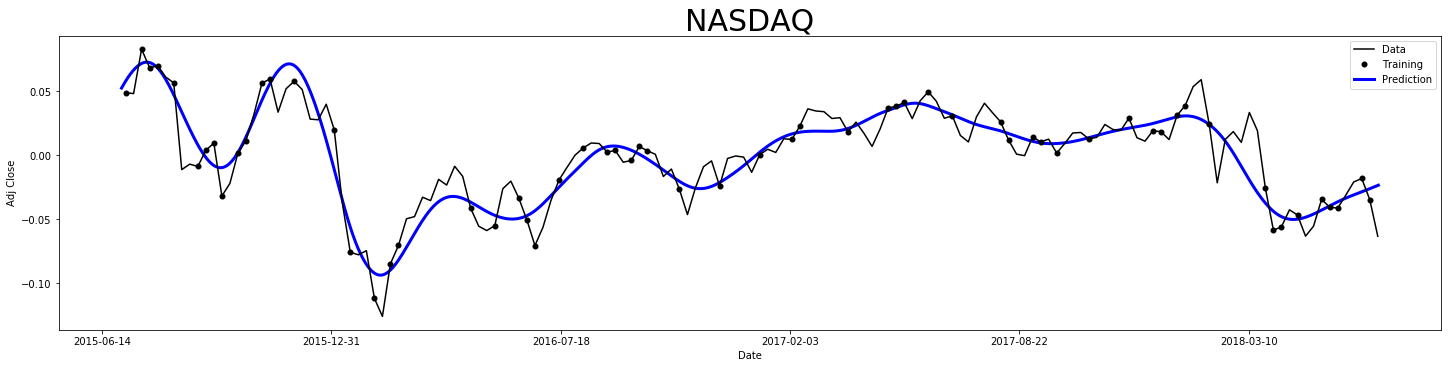

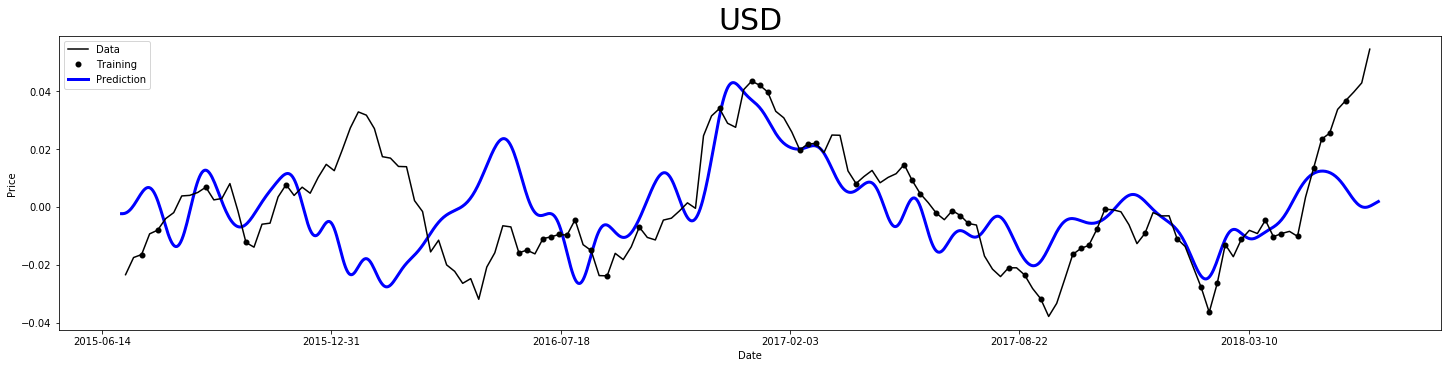

In [10]:
csm = mogptk.CSM(data, Q=3)
csm.init_params()
csm.train(tol=1e-6, maxiter=2000)
csm.print()

csm.predict()
csm.plot_data()

## SM-LMC

In [11]:
smlmc = mogptk.SM_LMC(data, Q=3)
smlmc.init_params()
smlmc.train(tol=1e-6, maxiter=2000)
smlmc.print()

smlmc.predict()
smlmc.plot_data()

NameError: name 'amplitudes' is not defined

## Results

In [ ]:
mogptk.errors(mosm, csm, smlmc, print=True)